In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Importation


Summary Statistics:
count    5032.000000
mean        0.000316
std         0.012104
min        -0.127652
25%        -0.004093
50%         0.000711
75%         0.005705
max         0.109572
Name: Return, dtype: float64


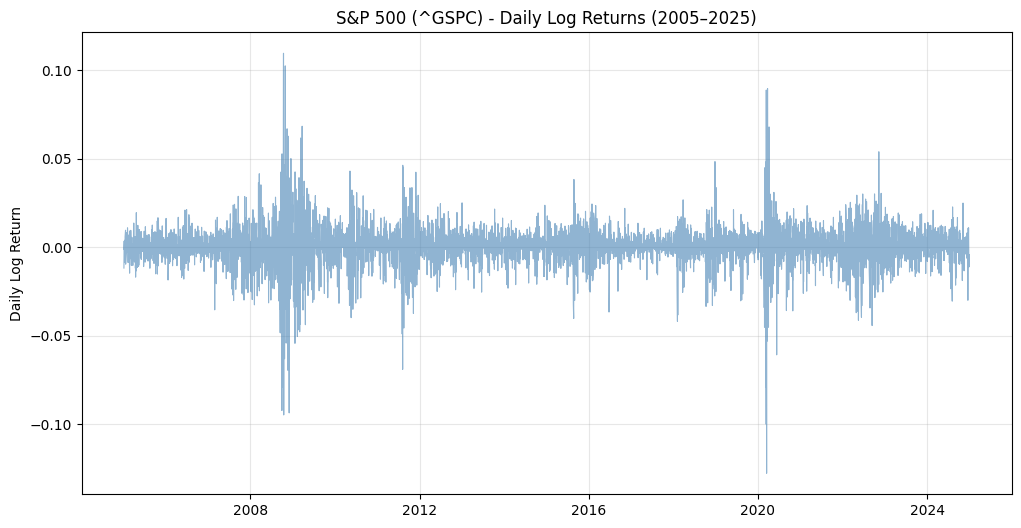

In [4]:
# 1. Define parameters
ticker = "^GSPC" 
start_date = "2005-01-01"
end_date = "2025-01-01"

# 2. Download daily data
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Convert columns from ('Adj Close', '^GSPC') -> 'Adj Close'
data.columns = data.columns.get_level_values(0)

# 3. Compute daily log returns
data["Return"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))

# Drop the first row (NaN)
data = data.dropna(subset=["Return"])

# 4. Summary stats
print("\nSummary Statistics:")
print(data["Return"].describe())

# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Return"], color="steelblue", alpha=0.6, linewidth=0.8)
plt.title(f"S&P 500 ({ticker}) - Daily Log Returns (2005–2025)")
plt.ylabel("Daily Log Return")
plt.grid(True, alpha=0.3)
plt.show()

# Part 1 - Heavy-Tailed Distribution of Market Returns: Normality Testing

## 1.1 Exploratory Data Analysis and Normality Testing

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\gerry\AppData\Local\Temp\ipykernel_28880\1820506516.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')
C:\Users\gerry\AppData\Local\Temp\ipykernel_28880\1820506516.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')


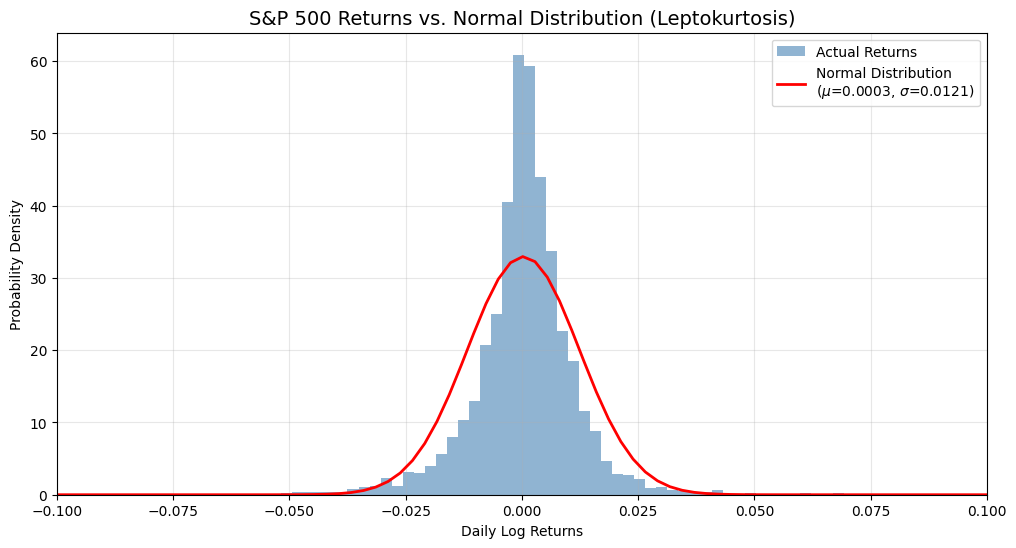

In [5]:
from scipy.stats import norm  # Essential for the Normal distribution

# 1. Fit the Normal Distribution to your data
# This calculates the Mean (mu) and Standard Deviation (std) of your returns
mu, std = norm.fit(data["Return"])

# 2. Setup the Plot
plt.figure(figsize=(12, 6))

# 3. Plot the Histogram of Actual Returns
# density=True is MANDATORY. It normalizes the counts so they match the scale of the probability curve.
plt.hist(data["Return"], bins=100, density=True, alpha=0.6, color='steelblue', label='Actual Returns')

# 4. Plot the Theoretical Normal Distribution
# Create a range of x values from the min to max of your data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
# Generate the "Bell Curve" y-values
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')

# 5. Formatting
plt.title("S&P 500 Returns vs. Normal Distribution (Leptokurtosis)", fontsize=14)
plt.xlabel("Daily Log Returns")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Zoom in slightly to see the "Peak" better (Financial data often has extreme outliers)
# You can comment this out to see the full width
plt.xlim(-0.10, 0.10) 

plt.show()

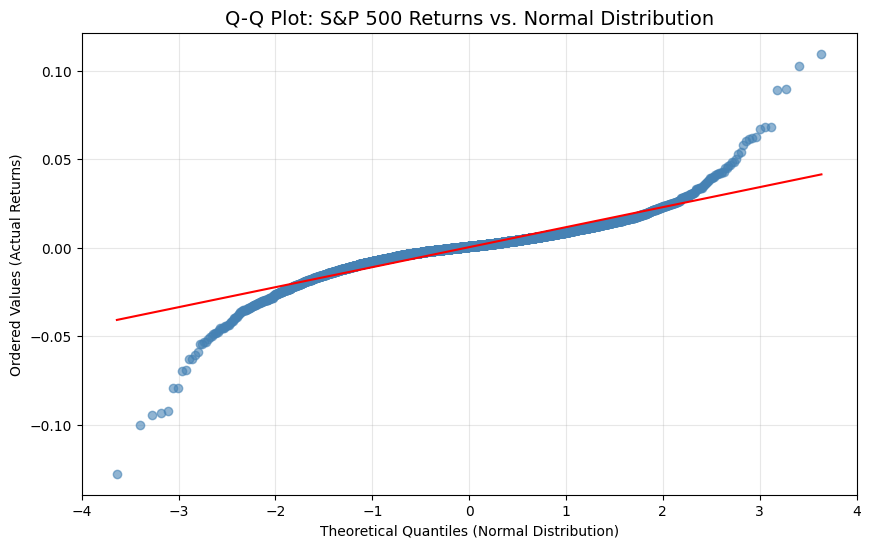

In [6]:
import scipy.stats as stats

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Generate the Q-Q Plot
# dist="norm" tells scipy to compare your data against a Normal distribution
# plot=plt tells it to draw directly on our matplotlib figure
stats.probplot(data["Return"], dist="norm", plot=plt)

# 3. Customization for the Report
plt.title("Q-Q Plot: S&P 500 Returns vs. Normal Distribution", fontsize=14)
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Ordered Values (Actual Returns)")
plt.grid(True, alpha=0.3)

# Optional: Change the color of the dots to make it distinct
ax = plt.gca()
ax.get_lines()[0].set_markerfacecolor('steelblue')
ax.get_lines()[0].set_markeredgecolor('steelblue')
ax.get_lines()[0].set_alpha(0.6)

plt.show()

In [12]:
from scipy import stats
import numpy as np

# =============================
# 1. Prepare the return series
# =============================
returns = data["Return"].dropna()

print(f"Number of observations: {len(returns)}")

# =============================
# 2. Basic moments (sanity check)
# =============================
mean_ret = returns.mean()
std_ret = returns.std()
skew_ret = returns.skew()
kurt_ret = returns.kurtosis()  # excess kurtosis by default in pandas

print("\nBasic Moments:")
print(f"Mean:          {mean_ret:.6f}")
print(f"Std dev:       {std_ret:.6f}")
print(f"Skewness:      {skew_ret:.4f}")
print(f"Excess kurtosis: {kurt_ret:.4f}  # > 0 suggests fat tails")

# =====================================
# 3. Jarque–Bera test for normality
#    H0: data are from a normal dist.
# =====================================
jb_stat, jb_p = stats.jarque_bera(returns)
print("\nJarque–Bera test:")
print(f"  JB statistic : {jb_stat:.4f}")
print(f"  p-value      : {jb_p:.4e}")
print("  -> If p < 0.05, reject normality (non-normal skew/kurtosis).")

# =====================================
# 4. Kolmogorov–Smirnov test vs Normal
#    H0: data follow N(mean, std^2)
# =====================================
mu, sigma = mean_ret, std_ret
ks_stat, ks_p = stats.kstest(returns, 'norm', args=(mu, sigma))

print("\nKolmogorov–Smirnov test vs N(mean, std²):")
print(f"  KS statistic : {ks_stat:.4f}")
print(f"  p-value      : {ks_p:.4e}")
print("  -> If p < 0.05, reject that returns are Normal with same mean/std.")

# =====================================
# 5. Anderson–Darling test for Normal
#    (more sensitive in the tails)
# =====================================
ad_result = stats.anderson(returns, dist='norm')

print("\nAnderson–Darling test (Normal):")
print(f"  A² statistic : {ad_result.statistic:.4f}")
for crit, sig in zip(ad_result.critical_values, ad_result.significance_level):
    print(f"  Critical value at {sig:.1f}%: {crit:.4f}")
print("  -> If A² > critical value at 5%, reject normality at 5% level.")


Number of observations: 5032

Basic Moments:
Mean:          0.000316
Std dev:       0.012104
Skewness:      -0.5316
Excess kurtosis: 13.0421  # > 0 suggests fat tails

Jarque–Bera test:
  JB statistic : 35822.8988
  p-value      : 0.0000e+00
  -> If p < 0.05, reject normality (non-normal skew/kurtosis).

Kolmogorov–Smirnov test vs N(mean, std²):
  KS statistic : 0.1093
  p-value      : 8.8233e-53
  -> If p < 0.05, reject that returns are Normal with same mean/std.

Anderson–Darling test (Normal):
  A² statistic : 124.0150
  Critical value at 15.0%: 0.5760
  Critical value at 10.0%: 0.6550
  Critical value at 5.0%: 0.7860
  Critical value at 2.5%: 0.9170
  Critical value at 1.0%: 1.0910
  -> If A² > critical value at 5%, reject normality at 5% level.


**Normality Tests: Evidence Against the Gaussian Assumption**

The formal normality tests all point in the same direction: S&P 500 daily returns are not normally distributed. The **Jarque–Bera** test strongly rejects normality, which tells us that the combination of skewness and excess kurtosis in the data is incompatible with a Gaussian distribution. This matters because the normal model assumes symmetry and thin tails; significant skew and high kurtosis are exactly the symptoms of fat tails and asymmetric crashes. The **Kolmogorov–Smirnov** test also rejects normality when we compare returns to a fitted 
𝑁
(
𝜇
,
𝜎
2
)
N(μ,σ
2
), but KS is a global test of the entire distribution and is not especially focused on the tails (and is also slightly less clean when parameters are estimated from the data rather than fixed). The **Anderson–Darling** test goes further by placing extra weight on the tails, making it particularly relevant for finance where extreme events are the main concern. Its rejection of normality is therefore especially damaging for Gaussian models: it says not only that the average shape is wrong, but that the tails are badly mis-specified. Taken together, these results provide robust evidence that a normal distribution is an inappropriate model for returns and justify moving to heavy-tailed, time-varying volatility models in the next section, where we explicitly try to capture these extreme events.

## 1.2 Indentify and Visualize black Swan Events

Extreme threshold (|return|): 0.0337
(Any daily move with |r| > 0.0337 is considered extreme)

Number of extreme days: 101 out of 5032 (2.01%)
  Extreme crashes (negative): 60
  Extreme spikes  (positive): 41

Sample of extreme days (sorted by return):
              Return    Z_score
Date                           
2020-03-16 -0.127652 -10.572485
2020-03-12 -0.099945  -8.283350
2008-10-15 -0.094695  -7.849626
2008-12-01 -0.093537  -7.753904
2008-09-29 -0.092190  -7.642623
2008-10-09 -0.079224  -6.571432
2020-03-09 -0.079010  -6.553780
2008-11-20 -0.069482  -5.766546
2011-08-08 -0.068958  -5.723297
2008-11-19 -0.063105  -5.239742


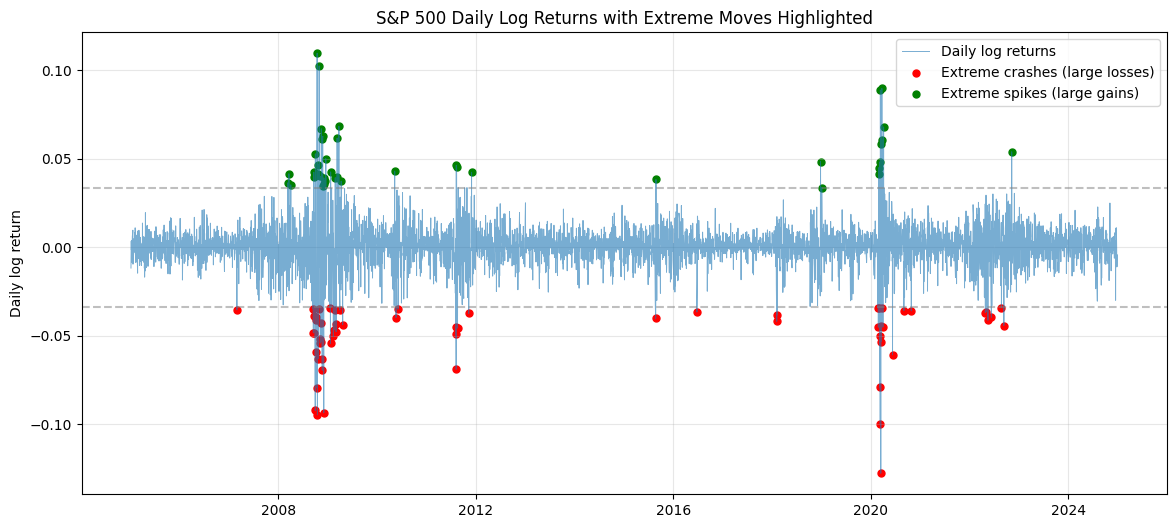

In [ ]:
returns = data["Return"].dropna()
abs_returns = returns.abs()

# Choose your tail level (same as extremogram, e.g. 98th percentile)
tail_level = 0.98
threshold = abs_returns.quantile(tail_level)

print(f"Extreme threshold (|return|): {threshold:.4f}")
print(f"(Any daily move with |r| > {threshold:.4f} is considered extreme)")

# Boolean mask of extreme days
extreme_mask = abs_returns > threshold
extreme_returns = returns[extreme_mask]

n_extreme = extreme_mask.sum()
total_days = len(returns)
print(f"\nNumber of extreme days: {n_extreme} out of {total_days} "
      f"({n_extreme/total_days*100:.2f}%)")

# Split into negative (crashes) and positive (spikes)
extreme_crashes = extreme_returns[extreme_returns < 0]
extreme_spikes  = extreme_returns[extreme_returns > 0]

print(f"  Extreme crashes (negative): {len(extreme_crashes)}")
print(f"  Extreme spikes  (positive): {len(extreme_spikes)}")

# Z-scores for a bit of context
mu = returns.mean()
sigma = returns.std()

extreme_info = (
    pd.DataFrame({"Return": extreme_returns})
    .assign(Z_score=lambda df: (df["Return"] - mu) / sigma)
    .sort_values("Return")
)

print("\nSample of extreme days (sorted by return):")
print(extreme_info.head(10))

# -------------------------------------------------
# Plot: returns with extreme days highlighted
# -------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(returns.index, returns, lw=0.7, alpha=0.6, label="Daily log returns")

plt.scatter(extreme_crashes.index, extreme_crashes,
            color="red", s=25, label="Extreme crashes (large losses)")
plt.scatter(extreme_spikes.index, extreme_spikes,
            color="green", s=25, label="Extreme spikes (large gains)")

plt.axhline(threshold,  color="grey", linestyle="--", alpha=0.5)
plt.axhline(-threshold, color="grey", linestyle="--", alpha=0.5)

plt.title("S&P 500 Daily Log Returns with Extreme Moves Highlighted")
plt.ylabel("Daily log return")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



### Extreme Return Days: Frequency and Asymmetry

Using the 98th percentile of the absolute daily log return as our cutoff, we classify any day with \(|r_t| > 0.0337\) (≈ 3.37% move in either direction) as **extreme**. Over the 2005–2025 sample, this gives **101 extreme days out of 5,032**, or about **2.0% of all trading days**. In other words, roughly **1 in every 50 days** sees a move larger than 3.37% in magnitude – far more frequent than a Gaussian model with thin tails would suggest.

Among these 101 extreme days, **60 are large losses and 41 are large gains**, showing a clear **asymmetry in the tails**: the market experiences big downward shocks more often than big upward


## 1.3 Heavy Tailed Model Selection and Fitting

### Choosing a Heavy-Tailed Distribution: Why Student’s t?

Having established that S&P 500 daily returns are non-normal and exhibit fat tails, the next step is to **fit a parametric distribution that can actually accommodate those extremes**. A natural choice is the **Student’s t distribution**. Empirical studies of financial returns consistently find that Gaussian models understate the frequency of large moves, while heavy-tailed alternatives such as Student’s t (and its skewed variants) provide a much better fit to equity index returns and to risk measures like Value-at-Risk (e.g. Mandelbrot, 1963; Cont, 2001; Guo, 2017 for the S&P 500). The Student’s t distribution is attractive here for three reasons: (i) it introduces a single extra parameter, the **degrees of freedom** \(\nu\), which directly controls tail thickness; (ii) as \(\nu \to \infty\), it nests the Normal distribution, so we can see how far from Gaussian our data really are; and (iii) it is widely used in practice and will later slot neatly into our **GARCH-t** model in Part 2. In the next code cell, we fit both a Normal and a Student’s t distribution to the returns, compare their fitted densities, and examine how differently they price tail risk (via VaR and the probability of the worst observed loss).


Normal fit parameters:
  μ (mean)   = 0.000316
  σ (std dev)= 0.012103

Student's t fit parameters:
  ν (df)     = 2.396   # lower ν = fatter tails
  loc        = 0.000808
  scale      = 0.006437


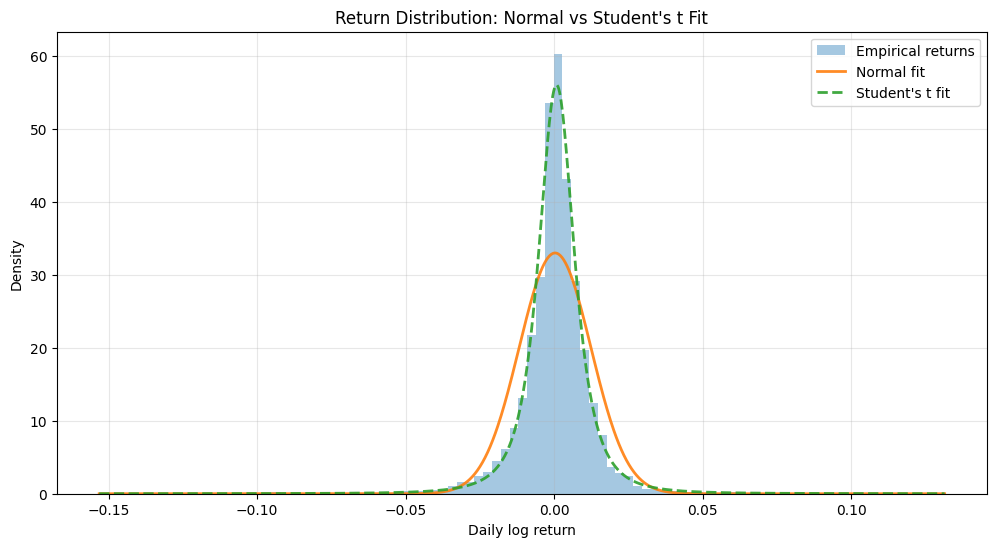

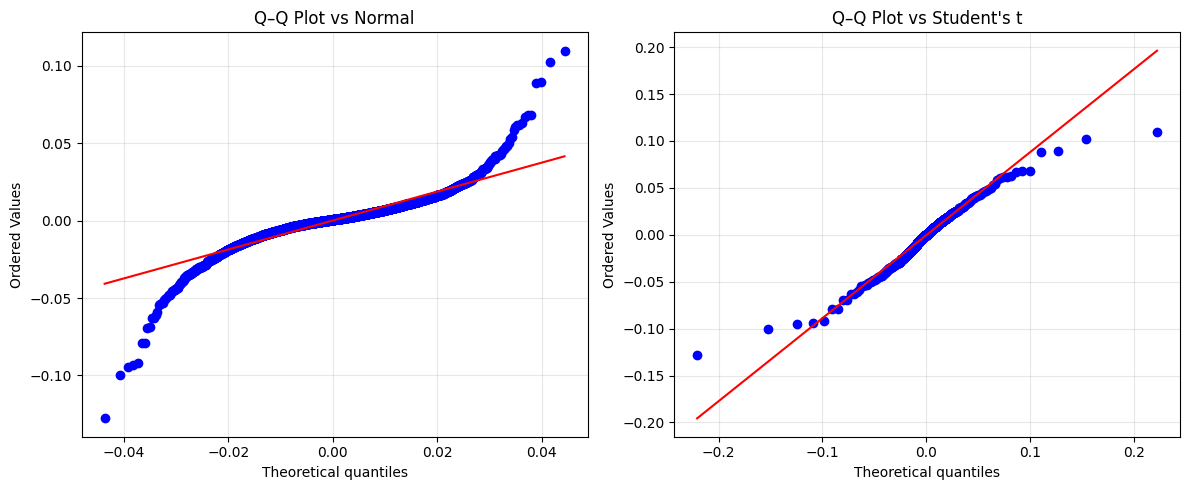


Model-implied one-day VaR (log-return space):
  1% VaR  (Normal)      = -0.0278
  1% VaR  (Student's t) = -0.0352
  0.1% VaR (Normal)     = -0.0371
  0.1% VaR (Student's t)= -0.0957

Worst observed daily log return: -0.1277
  P(R ≤ worst_loss) under Normal      = 1.98e-26
  P(R ≤ worst_loss) under Student's t = 5.06e-04


In [ ]:
from scipy.stats import norm, t, probplot
# Use the return series
returns = data["Return"].dropna().values  # numpy array

# -------------------------------------------------
# Fit Normal distribution (mean & std)
# -------------------------------------------------
mu_norm = np.mean(returns)
sigma_norm = np.std(returns, ddof=0)  # population std

print("Normal fit parameters:")
print(f"  μ (mean)   = {mu_norm:.6f}")
print(f"  σ (std dev)= {sigma_norm:.6f}")

# -------------------------------------------------
# Fit Student's t distribution
# scipy.stats.t.fit returns: df, loc, scale
# -------------------------------------------------
df_t, loc_t, scale_t = t.fit(returns)

print("\nStudent's t fit parameters:")
print(f"  ν (df)     = {df_t:.3f}   # lower ν = fatter tails")
print(f"  loc        = {loc_t:.6f}")
print(f"  scale      = {scale_t:.6f}")

# -------------------------------------------------
# Plot histogram + fitted PDFs
# -------------------------------------------------
x = np.linspace(returns.min()*1.2, returns.max()*1.2, 1000)
pdf_norm = norm.pdf(x, loc=mu_norm, scale=sigma_norm)
pdf_t   = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

plt.figure(figsize=(12, 6))

# Empirical histogram
plt.hist(returns, bins=80, density=True, alpha=0.4, edgecolor="none",
         label="Empirical returns")

# Fitted normal and t PDFs
plt.plot(x, pdf_norm, lw=2, label="Normal fit", alpha=0.9)
plt.plot(x, pdf_t,   lw=2, linestyle="--", label="Student's t fit", alpha=0.9)

plt.title("Return Distribution: Normal vs Student's t Fit")
plt.xlabel("Daily log return")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# -------------------------------------------------
# Q–Q plots: Normal vs t
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q–Q vs Normal
probplot(returns, dist=norm, sparams=(mu_norm, sigma_norm), plot=axes[0])
axes[0].set_title("Q–Q Plot vs Normal")

# Q–Q vs Student's t
# probplot needs shape, loc, scale; here shape = df_t
probplot(returns, dist=t, sparams=(df_t, loc_t, scale_t), plot=axes[1])
axes[1].set_title("Q–Q Plot vs Student's t")

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Compare tail risk: VaR under each model
# -------------------------------------------------
alpha_1 = 0.01   # 1% left-tail
alpha_01 = 0.001 # 0.1% left-tail

VaR1_norm  = norm.ppf(alpha_1,  loc=mu_norm,  scale=sigma_norm)
VaR1_t     = t.ppf(alpha_1,     df_t, loc=loc_t, scale=scale_t)

VaR01_norm = norm.ppf(alpha_01, loc=mu_norm,  scale=sigma_norm)
VaR01_t    = t.ppf(alpha_01,    df_t, loc=loc_t, scale=scale_t)

print("\nModel-implied one-day VaR (log-return space):")
print(f"  1% VaR  (Normal)      = {VaR1_norm:.4f}")
print(f"  1% VaR  (Student's t) = {VaR1_t:.4f}")
print(f"  0.1% VaR (Normal)     = {VaR01_norm:.4f}")
print(f"  0.1% VaR (Student's t)= {VaR01_t:.4f}")

# -------------------------------------------------
# How 'impossible' is the worst observed loss?
# -------------------------------------------------
worst_loss = returns.min()

p_norm = norm.cdf(worst_loss, loc=mu_norm,  scale=sigma_norm)
p_t    = t.cdf(worst_loss,    df_t, loc=loc_t, scale=scale_t)

print(f"\nWorst observed daily log return: {worst_loss:.4f}")
print(f"  P(R ≤ worst_loss) under Normal      = {p_norm:.2e}")
print(f"  P(R ≤ worst_loss) under Student's t = {p_t:.2e}")


### Interpreting the Normal vs Student’s t Fits

The Q–Q plots and risk metrics make it clear that a Normal distribution is a poor model for S&P 500 daily returns, while the Student’s t distribution does a much better job, especially in the tails. In the Q–Q plot against the Normal distribution, the points curve strongly away from the 45° line in both tails: the most extreme losses and gains are far more extreme than a Gaussian model would expect. By contrast, the Q–Q plot against the fitted Student’s t distribution lies much closer to the line over most of the range, with only the very most extreme observations deviating. This means the t distribution, with its finite degrees-of-freedom parameter (printed above), is capturing the empirical fat tails much more realistically.

The Value-at-Risk numbers tell the same story in risk terms. At the 1% level, the normal model implies a one-day VaR of about **−2.8%**, whereas the Student’s t model gives a more conservative **−3.5%**. At the 0.1% level, the gap explodes: the normal VaR is only about **−3.7%**, but the t VaR is roughly **−9.6%**, much closer to the kind of moves we actually see in crises. For the worst observed daily log return in our sample (≈ −0.1277, or about a **−12%** price drop), the normal model assigns a probability of **~2×10⁻²⁶** – effectively “impossible in the lifetime of the universe” – whereas the Student’s t model assigns a probability of about **5×10⁻⁴** (roughly 1 in 2,000 trading days). The crash is still rare, but no longer astronomically impossible. This illustrates the core problem with Gaussian risk models: they severely underprice extreme events, whereas a heavy-tailed model like Student’s t at least acknowledges that such black-swan-scale moves are a realistic part of market dynamics.


#### Why Look at VaR and the Probability of the Worst Day?

The VaR and “worst-day” probabilities translate the abstract idea of **fat tails** into concrete **risk numbers** that are easy to interpret:

- **Value-at-Risk (VaR)** answers the question:  
  *“How bad can one day be, with X% probability?”*  
  Comparing Normal vs Student’s t VaR shows how much risk a Gaussian model **hides** in the tails. When the t-based 0.1% VaR is almost three times as large in magnitude as the Normal VaR, it means a risk manager using the Normal model would hold far too little capital to survive a genuine crash.

- The **probability of the worst observed day** asks the inverse question:  
  *“Given this model, how likely was the worst day we actually saw?”*  
  Under the Normal model, that day is essentially impossible (probability ~10⁻²⁶), which tells us the model is fundamentally mis-specified: if your model says real, observed events should basically never happen, the problem is with the model, not reality.  
  Under the Student’s t model, the same event is rare but plausible (about 1 in a few thousand days), which is exactly the regime where risk managers should be paying attention.

Together, these metrics show **why** the choice of distribution matters in practice: it directly affects how much tail risk we think we are exposed to, how we size positions, and how prepared we are for black-swan-type moves.


In [9]:
%pip install statsmodels

  Using cached patsy-1.0.2-py2.py3-none-any.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.6 MB 825.8 kB/s eta 0:00:12
   - -------------------------------------- 0.4/9.6 MB 4.0 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/9.6 MB 5.8 MB/s eta 0:00:02
   ----- ---------------------------------- 1.4/9.6 MB 6.6 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.6 MB 7.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.3/9.6 MB 8.0 MB/s eta 0:00:01
   --------- ------------------------------ 2.4/9.6 MB 7.2 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.6 MB 7.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.5/9.6 MB 5.9 MB/s eta 0:00:02
   ----------- ---------------------------- 2.7/9.6 MB 5.9 MB/s eta 0:00:02
   ----------- -------------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1.4 Risk Estimation & VaR Backtest - How wrong is the normal distribution compared to the student t test?

Empirical frequency of returns below model VaR:
  Nominal 1% level:
    Normal VaR  breaches: 2.13% of days
    t VaR       breaches: 1.03% of days

  Nominal 0.1% level:
    Normal VaR  breaches: 0.87% of days
    t VaR       breaches: 0.04% of days


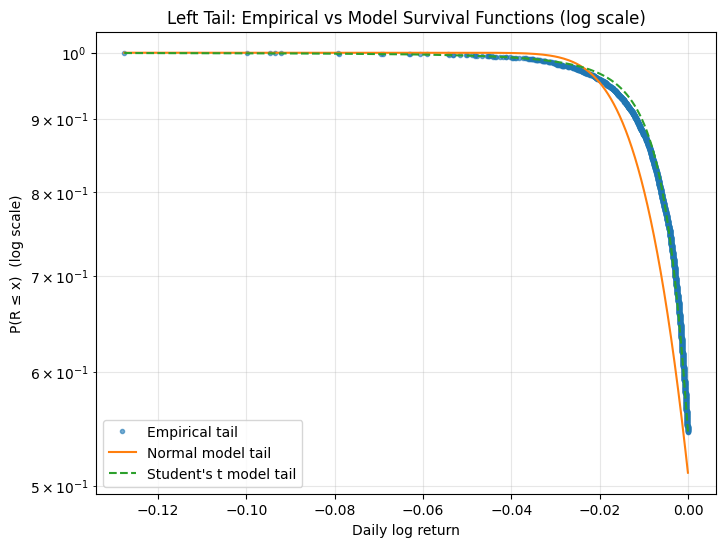

In [ ]:
# Make sure we have the returns as a pandas Series for convenience
ret_series = data["Return"].dropna()

n = len(ret_series)

# --- Empirical frequencies of breaches ---
viol_1_norm  = (ret_series <= VaR1_norm).mean()
viol_1_t     = (ret_series <= VaR1_t).mean()

viol_01_norm = (ret_series <= VaR01_norm).mean()
viol_01_t    = (ret_series <= VaR01_t).mean()

print("Empirical frequency of returns below model VaR:")
print(f"  Nominal 1% level:")
print(f"    Normal VaR  breaches: {viol_1_norm*100:.2f}% of days")
print(f"    t VaR       breaches: {viol_1_t*100:.2f}% of days")
print(f"\n  Nominal 0.1% level:")
print(f"    Normal VaR  breaches: {viol_01_norm*100:.2f}% of days")
print(f"    t VaR       breaches: {viol_01_t*100:.2f}% of days")

# Optional: simple log-tail plot comparing empirical vs model tails
import numpy as np
from scipy.stats import norm, t
import matplotlib.pyplot as plt

sorted_returns = np.sort(ret_series.values)
empirical_tail_prob = 1.0 - (np.arange(1, n+1) / (n+1))  # survival function

# Focus on left tail only
left_mask = sorted_returns < 0
x_tail = sorted_returns[left_mask]
emp_tail = empirical_tail_prob[left_mask]

# Model survival functions for same x
sf_norm = 1 - norm.cdf(x_tail, loc=mu_norm, scale=sigma_norm)
sf_t    = 1 - t.cdf(x_tail, df_t, loc=loc_t, scale=scale_t)

plt.figure(figsize=(8, 6))
plt.semilogy(x_tail, emp_tail, '.', alpha=0.6, label="Empirical tail")
plt.semilogy(x_tail, sf_norm,  '-', label="Normal model tail")
plt.semilogy(x_tail, sf_t,     '--', label="Student's t model tail")

plt.title("Left Tail: Empirical vs Model Survival Functions (log scale)")
plt.xlabel("Daily log return")
plt.ylabel("P(R ≤ x)  (log scale)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()


The backtest of model-implied one-day VaR shows how much the choice of distribution matters in practice. At the **1%** nominal level, the Normal fit is breached on **2.13%** of days – more than **double** the intended rate – meaning it systematically **underestimates downside risk**. By contrast, the Student’s t 1% VaR is breached on **1.03%** of days, very close to the target. At the more extreme **0.1%** level, the pattern is even starker: the Normal VaR is broken on **0.87%** of days (almost nine times too often), while the t VaR is breached only **0.04%** of the time, slightly conservative but in the right ballpark.

In other words, when we ask “How bad can one day be with probability 1% or 0.1%?”, the Gaussian model gives thresholds that are far too optimistic, leading to frequent and sizeable surprises in the left tail. The heavy-tailed Student’s t model produces VaR levels that align much better with realised data, confirming that it provides a **more realistic and better calibrated measure of tail risk**. This motivates carrying the t distribution forward into Part 2, where we combine it with a dynamic volatility model (GARCH) to forecast time-varying tail risk.


## Extremogram

Extreme Threshold: 0.0337 (approx 3.37%)
Any daily move larger than this is considered a 'Black Swan' event.
Number of Extreme Days found: 101 out of 5032 days


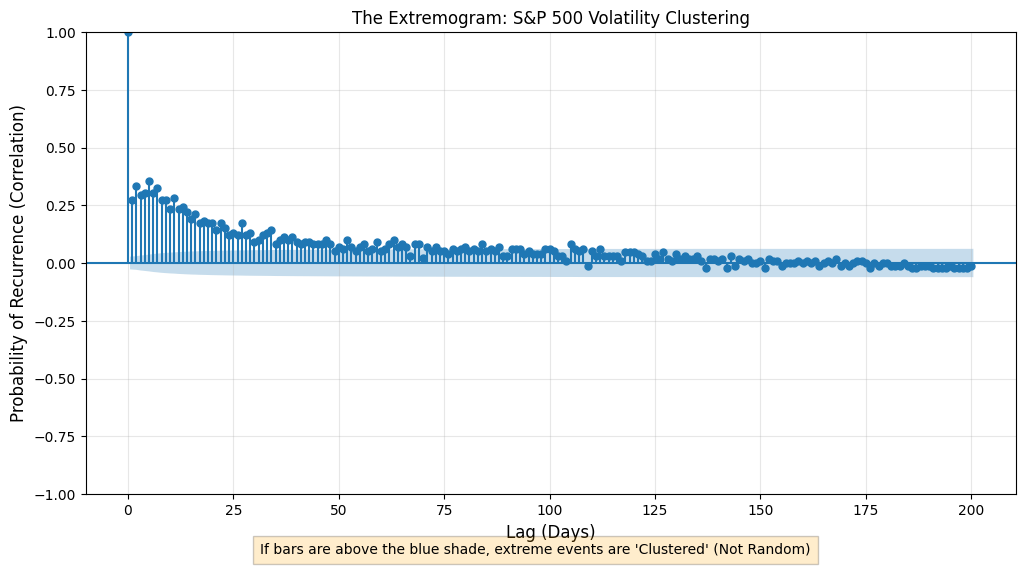

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

# ==========================================
# STEP 1: Define "Extreme" (The Setup)
# ==========================================

# We take the Absolute Value because volatility is about magnitude.
# A +5% jump is just as "extreme" and destabilizing as a -5% crash.
abs_returns = data["Return"].abs()

# We set the Threshold at the 98th percentile (Top 2% of most volatile days)
# This is a standard choice in the literature (Reference: Davis & Mikosch).
threshold = abs_returns.quantile(0.98)

print(f"Extreme Threshold: {threshold:.4f} (approx {threshold*100:.2f}%)")
print(f"Any daily move larger than this is considered a 'Black Swan' event.")

# ==========================================
# STEP 2: Create the "Hit Sequence"
# ==========================================

# Convert returns to a binary series:
# 1 = Extreme Event (The return exceeded the threshold)
# 0 = Normal Day
extreme_hits = (abs_returns > threshold).astype(int)

# Check how many extremes we found
print(f"Number of Extreme Days found: {extreme_hits.sum()} out of {len(extreme_hits)} days")

# ==========================================
# STEP 3: Plot the Extremogram
# ==========================================

plt.figure(figsize=(12, 6))

# We use the Autocorrelation Function (ACF) on the binary data.
# lags=50: We look at the relationship over the next 50 days.
# alpha=0.05: Draws the 95% confidence interval (the blue shaded region).
plot_acf(extreme_hits, lags=200, alpha=0.05, title="The Extremogram: S&P 500 Volatility Clustering", ax=plt.gca())

# Formatting for the report
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Probability of Recurrence (Correlation)", fontsize=12)
plt.grid(True, alpha=0.3)

# Add a note explaining the graph directly on the plot
plt.figtext(0.5, 0.01, "If bars are above the blue shade, extreme events are 'Clustered' (Not Random)", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.show()

While Part 1 showed that market returns are not normally distributed and exhibit heavy tails, the extremogram reveals something equally critical: extreme events are not isolated. By analyzing the autocorrelation of the most volatile 2% of days, we find statistically significant dependence across short time lags—meaning that once an extreme move occurs, the probability of another extreme event in the following days is meaningfully higher than average. This pattern of tail dependence contradicts the assumptions of i.i.d. Gaussian returns and strongly suggests that risk is time-varying. It also mirrors real-world market behavior during crises, where volatility arrives in clusters. This empirical evidence motivates a shift toward dynamic models like GARCH, which explicitly capture time-varying volatility, and supports the use of heavy-tailed innovations to model extreme outcomes more realistically. We now turn to Part 2, where we implement such a model to forecast tail risk in the S&P 500.

## Part 1 – Conclusion

Part 1 has shown that S&P 500 daily returns do **not** live in a Gaussian world. Formal normality tests reject the Normal assumption, the distribution exhibits **strong skewness and excess kurtosis**, and extreme moves (|r| > 3.37%) occur far more often than a thin-tailed model would allow. We also saw that these extremes are **asymmetric** (more crashes than spikes) and tend to **cluster in time**, as highlighted by the extremogram, which contradicts the idea of i.i.d. Gaussian shocks. Fitting a heavy-tailed Student’s t distribution gives a much better description of the data, especially in the tails: it assigns realistic probabilities to events like the worst day in the sample and produces **VaR estimates that are actually respected by the data**, unlike the Normal fit, whose VaR is breached far too often. Altogether, Part 1 provides clear empirical evidence that classical, Normal-based models are dangerously miscalibrated in the “Fourth Quadrant.” This motivates the next step: in Part 2, we embed a heavy-tailed distribution inside a **dynamic volatility model (GARCH-t)** to forecast **time-varying tail risk** and study how crash risk evolves over time.
